In [13]:
from kaggle_environments import make

from pypad.solvers.mcts import MctsSolver
from pypad.games import ConnectX, TicTacToe

# Tic-Tac-Toe Kaggle Battle

In [15]:
tictactoe = TicTacToe()

player_1000 = MctsSolver(1_000)
player_100 = MctsSolver(1_00)

agent_1000 = tictactoe.create_agent(player_1000)
agent_100 = tictactoe.create_agent(player_100)

# Run on the Kaggle environment
env = make(tictactoe.name, debug=True)
env.run([agent_1000, agent_100])
env.render(mode="ipython")

# Tree Search Visualization

In [16]:
state = tictactoe.initial_state("0,1,8,5,6")
state

,a,b,c
3,⭕,✖️,
2,,,✖️
1,⭕,,⭕


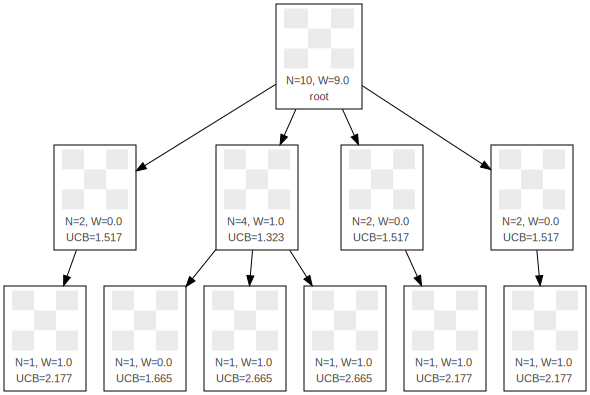

In [17]:
mcts = MctsSolver(10)
root = mcts.search(state)
root.render(state)

# ConnectX Kaggle Battle

In [18]:
connectx = ConnectX()

player_1000 = MctsSolver(1_000)
player_100 = MctsSolver(1_00)

agent_1000 = connectx.create_agent(player_1000)
agent_100 = connectx.create_agent(player_100)

# Run on the Kaggle environment
env = make(connectx.name, debug=True)
env.run([agent_100, agent_1000])
env.render(mode="ipython")

In [19]:
state = connectx.initial_state("3,3,4,5,3,4,5,5,6")
state

,1,2,3,4,5,6,7
6,,,,,,,
5,,,,,,,
4,,,,,,,
3,,,⭕,,✖️,,
2,,,✖️,✖️,⭕,,
1,,,⭕,⭕,✖️,⭕,


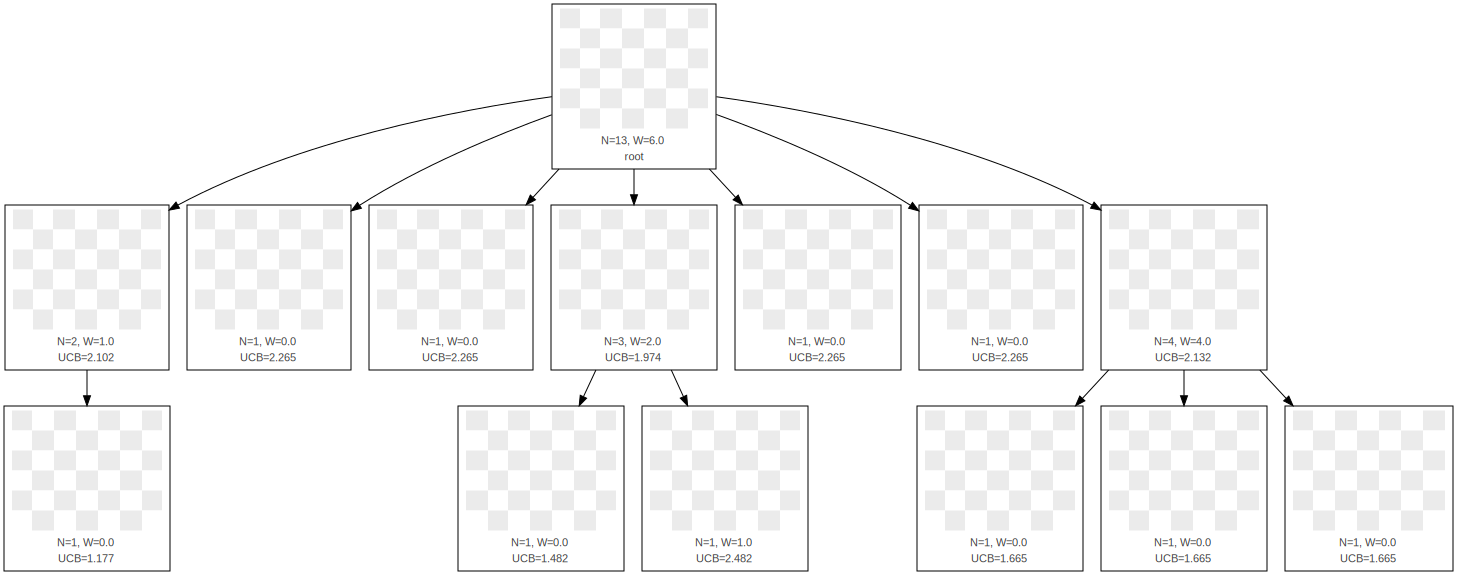

In [20]:
mcts = MctsSolver(13)
root = mcts.search(state)
root.render(state)

# ConnectX (Negamax)

In [12]:
from pypad.states import ConnectXState
from functools import partial
import numpy as np
from copy import copy

game = ConnectX()

# Helper function for score_move: calculates value of heuristic for grid
def get_heuristic(board) -> int:
    rows = board.rows + 1
    directions = (1, rows - 1, rows, rows + 1)
    bitboard = board.position ^ board.mask
    bitboard2 = board.position
    score = 0
    for dir in directions:
        if result := bitboard & (bitboard >> dir) & (bitboard >> 2 * dir):
            score += 0.2 * result.bit_count()
            
        if result := bitboard2 & (bitboard2 >> dir) & (bitboard2 >> 2 * dir):
            score -= 0.1 * result.bit_count()
            
    return score


def shallow_negamax(board: ConnectXState, alpha: int, beta: int, depth: int) -> int:
    if board.is_full():
        return 0

    win_mask = board.win_mask()
    possible_moves = board.possible_moves_mask()
    if (win_mask & possible_moves):
        return (board.num_slots - board.num_moves + 1) // 2

    max_possible_score = (board.num_slots - board.num_moves - 1) // 2
    if max_possible_score <= alpha:
        return max_possible_score
    
    if depth == 0:
        return get_heuristic(board)

    alpha = -100_000_000
    beta = min(beta, max_possible_score)

    for move in board.possible_moves():
        b = copy(board)
        b.play_move(move)
        score = -shallow_negamax(b, -beta, -alpha, depth - 1)
        alpha = max(alpha, score)
        if score >= beta:
            return alpha

    return alpha

def agent_negamax(obs, config, depth):

    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    board = ConnectXState.from_grid(grid)

    best_col, best_score = next(board.possible_col_moves()), -1_000_000

    for col in board.possible_col_moves():
        b = copy(board)
        b.play_col(col)
        if b.is_won():
            return col

    for col in board.possible_col_moves():
        b = copy(board)
        b.play_col(col)
        alpha, beta = -1, 1
        score = -shallow_negamax(b, alpha, beta, depth)
        if score > best_score:
            best_score = score
            best_col = col
            
    return best_col


agent_negamax5 = partial(agent_negamax, depth=4)
agent_negamax2 = partial(agent_negamax, depth=1)

player_1000 = MctsSolver(1_000)
agent_1000 = game.create_agent(player_1000)

# Setup a ConnectX environment.
env = make(game.name, debug=True)
env.run([agent_negamax5, agent_1000])
env.render(mode="ipython")

Traceback (most recent call last):
  File "C:\Users\alexj\Documents\git\PyPad\.venv\Lib\site-packages\kaggle_environments\agent.py", line 159, in act
    action = self.agent(*args)
             ^^^^^^^^^^^^^^^^^
  File "C:\Users\alexj\AppData\Local\Temp\ipykernel_13760\3347913457.py", line 59, in agent_negamax
    best_col, best_score = next(board.possible_col_moves()), -1_000_000
                                ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'ConnectXState' object has no attribute 'possible_col_moves'
Error: ['Traceback (most recent call last):\n', '  File "C:\\Users\\alexj\\Documents\\git\\PyPad\\.venv\\Lib\\site-packages\\kaggle_environments\\agent.py", line 159, in act\n    action = self.agent(*args)\n             ^^^^^^^^^^^^^^^^^\n', '  File "C:\\Users\\alexj\\AppData\\Local\\Temp\\ipykernel_13760\\3347913457.py", line 59, in agent_negamax\n    best_col, best_score = next(board.possible_col_moves()), -1_000_000\n                                ^^^^^^^^^^^^^^^^^^^^^^^^\n

In [ ]:
def diagnose(n: int, verbose: bool = True):
    obs = env.steps[n-1][0]['observation']
    config = env.configuration
    
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    state = ConnectXState.from_grid(grid)
    
    if verbose:
        print(f'Last played by: {state.played_by}')
        print(f'Next to play:   {3 - state.played_by}\n')
        print(grid)
    return obs, config, state

n = 12
depth = 4
obs, config, state = diagnose(n)

col = agent_1000(obs, config)
col = agent_negamax(obs, config, depth)
print(f'\nSuggested col = {col}')
state

In [ ]:
ROWS, COLS = 6, 7
moves = [2,3,2,5,7]
moves = [3,3,4,4]
state = ConnectXState.create(ROWS, COLS, moves)

for col in state.possible_col_moves():
    b = copy(state)
    b.play_col(col)
    alpha, beta, depth = -1, 1, 9
    score = -shallow_negamax(b, alpha, beta, depth)
    print(f'[{col}] Score={score}')


In [ ]:
solver = MiniMaxSolver()

moves = [6,4,1,1,5,4,4,2,2,6,5,7,5,7,2,5,3,6,1,5]
state = ConnectXState.create(ROWS, COLS, moves)

for col in state.possible_col_moves():
    b = copy(state)
    b.play_col(col)
    score = -solver.minimax(b, -1, 1)
    print(f'[{col}] Score={score}')